In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm
from scipy.optimize import minimize
from sklearn.model_selection import GridSearchCV

class WeatherModel():
    def __init__(self, filename, start_year=2003, end_year=2024):
        self.data = pd.read_csv(filename)
        self.data = self.data.drop(columns=['GUST', 'SNDP', 'STP'])
        self.data = self.data.replace(999.9, pd.NA)
        self.data = self.data.replace(9999.9, pd.NA)
        self.data['PRCP'] = self.data['PRCP'].replace(99.99, pd.NA)
        self.data['DATE'] = pd.to_datetime(self.data['DATE'])
        self.data = self.data[(self.data['DATE'].dt.year >= start_year) & (self.data['DATE'].dt.year <= end_year)]
        self.data = self.data[~((self.data['DATE'].dt.month == 2) & (self.data['DATE'].dt.day == 29))]
        self.data = self.data.ffill()

        self.seasonal = None
        self.residuals = None

        self.year_data = self.get_year_data()
        self.arma_models = []

    def get_year_data(self):
        data = self.data[["MAX", "MIN", "TEMP", "MXSPD", "PRCP", "DEWP"]]
        data = data.to_numpy()

        drop_rows = data.shape[0] % 365
        data = data[:-drop_rows]

        data = data.reshape(-1, 365, data.shape[1])

        return data

    def get_seasonal_trend(self):
        
        seasonal = np.mean(self.year_data, axis=0)
        self.seasonal = seasonal

        return seasonal
    
    def get_residuals(self):
        
        if self.seasonal is None:
            self.get_seasonal_trend()

        residuals = self.year_data - self.seasonal
        residuals = residuals.reshape(-1, residuals.shape[2])
        self.residuals = residuals

        return residuals
    
    def fit_arma(self, order, train_stop = None):

        if train_stop is None:

            if self.residuals is None:
                self.get_residuals()

            arma_models = []

            pbar = tqdm(total=self.residuals.shape[1])

            for i in range(self.residuals.shape[1]):
                pbar.set_description(f"Fitting {i+1}/{self.residuals.shape[1]} ARMA models")
                pbar.update(1)
                model = ARIMA(self.residuals[:, i], order=order)
                model_fit = model.fit()
                arma_models.append(model_fit)
                
            self.arma_models = arma_models

            return None
        else:

            if self.residuals is None:
                self.get_residuals()

            arma_models = []

            pbar = tqdm(total=self.residuals[:,train_stop].shape[1])

            for i in range(self.residuals.shape[:,train_stop][1]):
                pbar.set_description(f"Fitting {i+1}/{self.residuals.shape[1]} ARMA models")
                pbar.update(1)
                model = ARIMA(self.residuals[:, i], order=order)
                model_fit = model[:,train_stop].fit()
                arma_models.append(model_fit)
                
            self.arma_models = arma_models

            return None

    def fit(self, order):
        self.fit_arma(order)
        return None
    
    def predict(self, start=0, future=0):
        if len(self.arma_models) == 0:
            raise ValueError("Model not fitted yet")

        arma_predictions = np.array([model.predict(start=start, end=len(self.residuals) - start + future) for model in self.arma_models])

        season_start = start % 365
                
        num_stacks = arma_predictions.shape[1] // self.seasonal.shape[0]
        num_extras = arma_predictions.shape[1] % self.seasonal.shape[0]


        seasonal_predictions = np.vstack([self.seasonal for _ in range(num_stacks)])
        print("Seasonal Predictions", seasonal_predictions.shape)
        print("Residual shape", arma_predictions.shape)
        print("Num stacks", num_stacks)
        print("Num extras", num_extras)

        if num_extras > 0:
            seasonal_predictions = np.vstack((seasonal_predictions, self.seasonal[:num_extras].reshape(num_extras, -1)))



        return seasonal_predictions.T + arma_predictions
    



/var/folders/gx/9rfpwcnn3nv1fbw39974s9vh0000gn/T/ipykernel_25633/2079343653.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.data = self.data.ffill()
/var/folders/gx/9rfpwcnn3nv1fbw39974s9vh0000gn/T/ipykernel_25633/2079343653.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.data = self.data.ffill()
Fitting 6/6 ARMA models: 100%|████████████████████| 6/6 [00:02<00:00,  2.64it/s]


Seasonal Predictions (11315, 6)
Residual shape (6, 11316)
Num stacks 31
Num extras 1


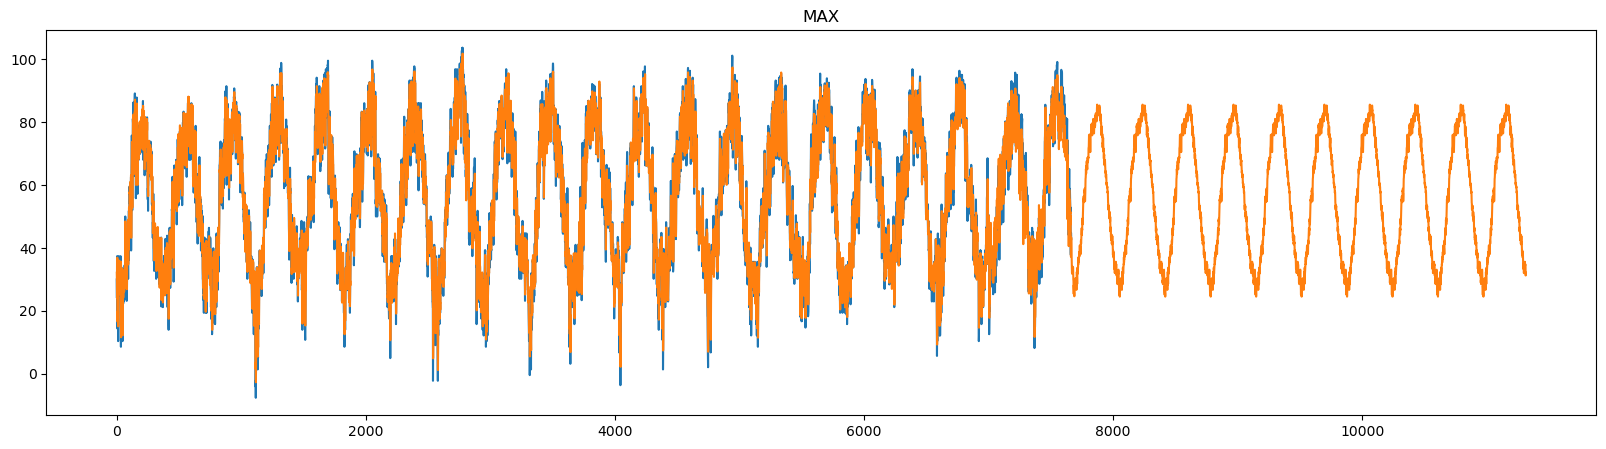

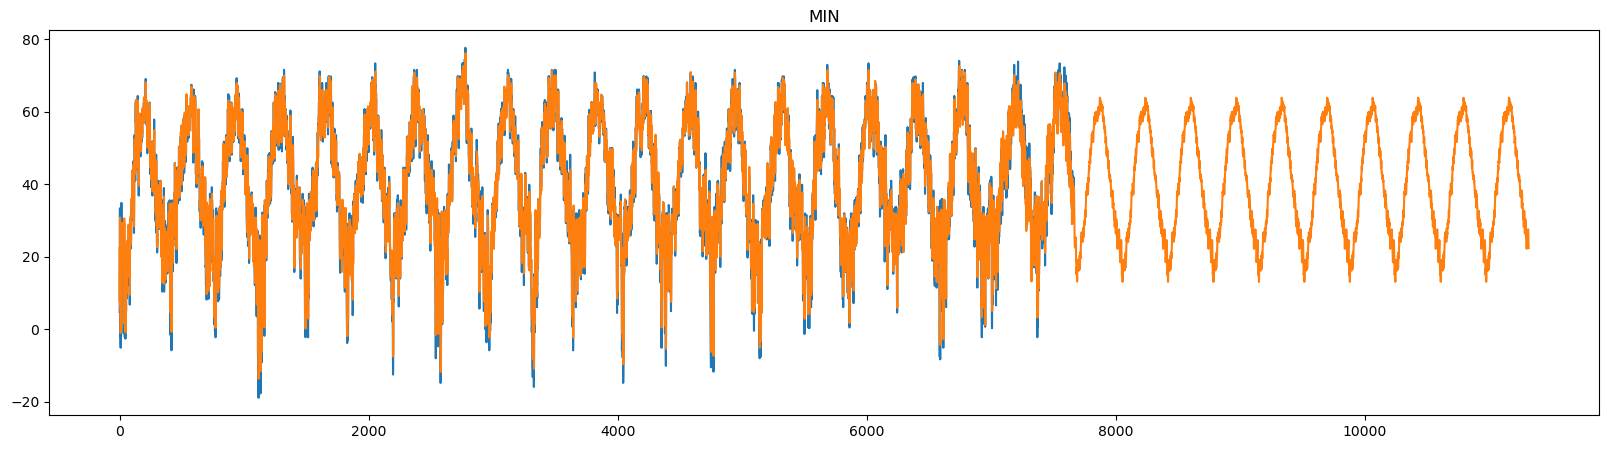

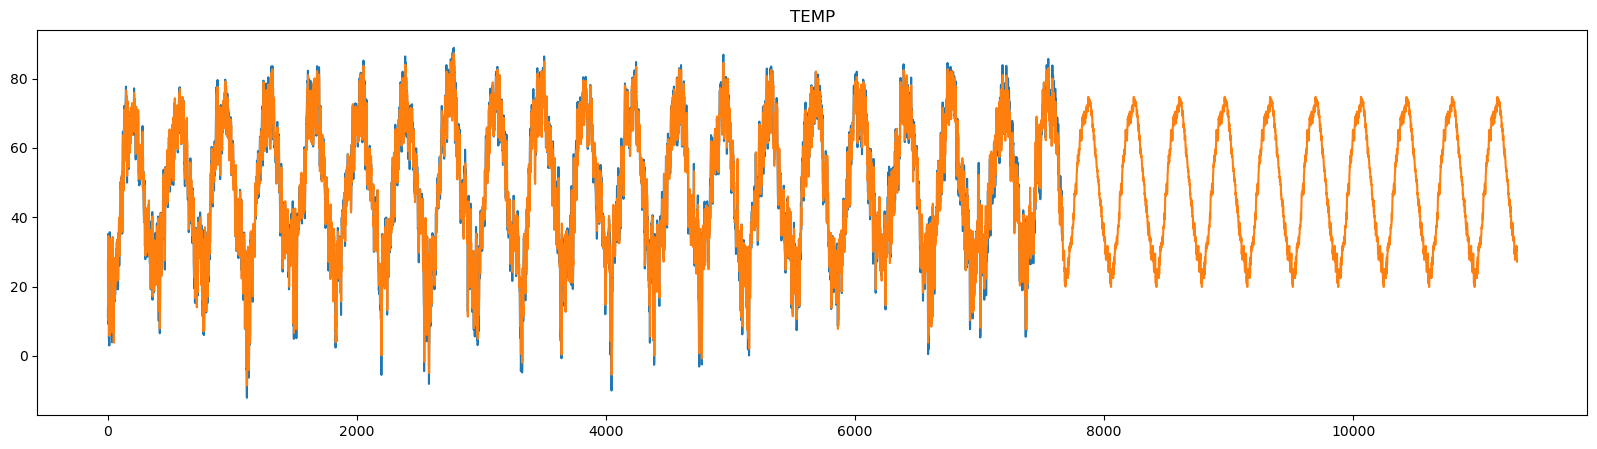

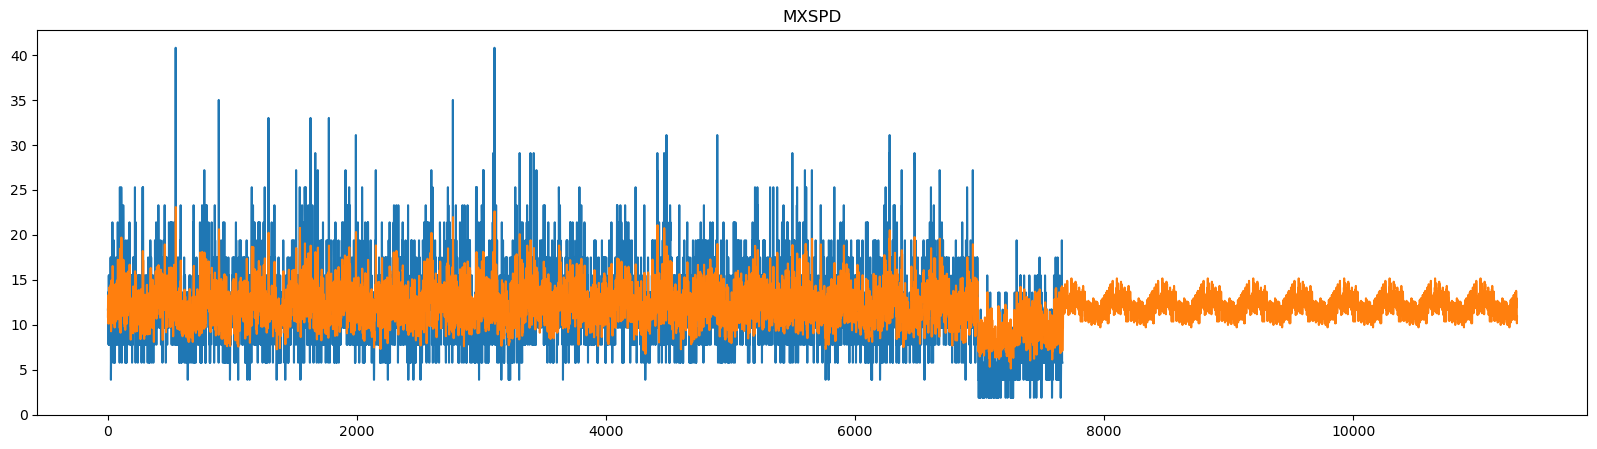

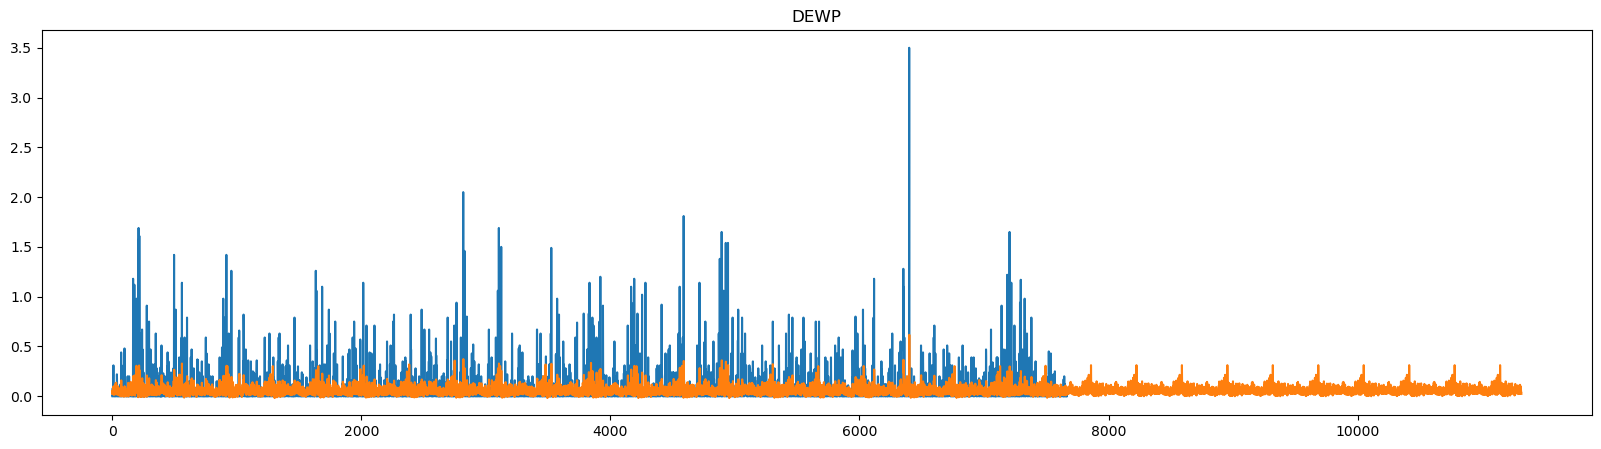

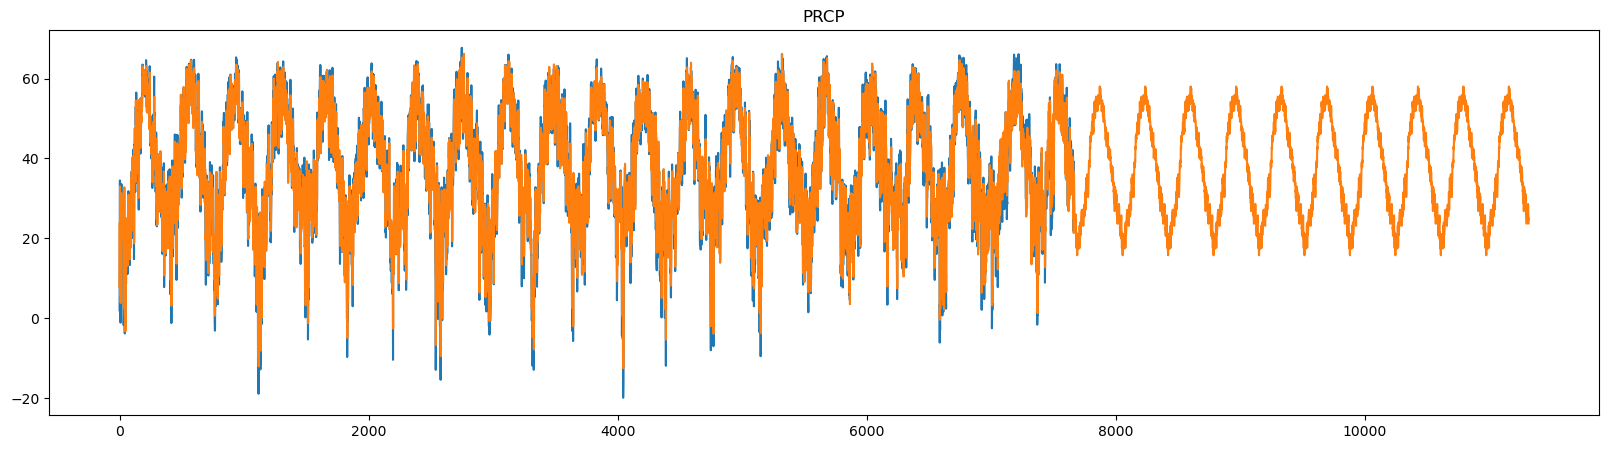

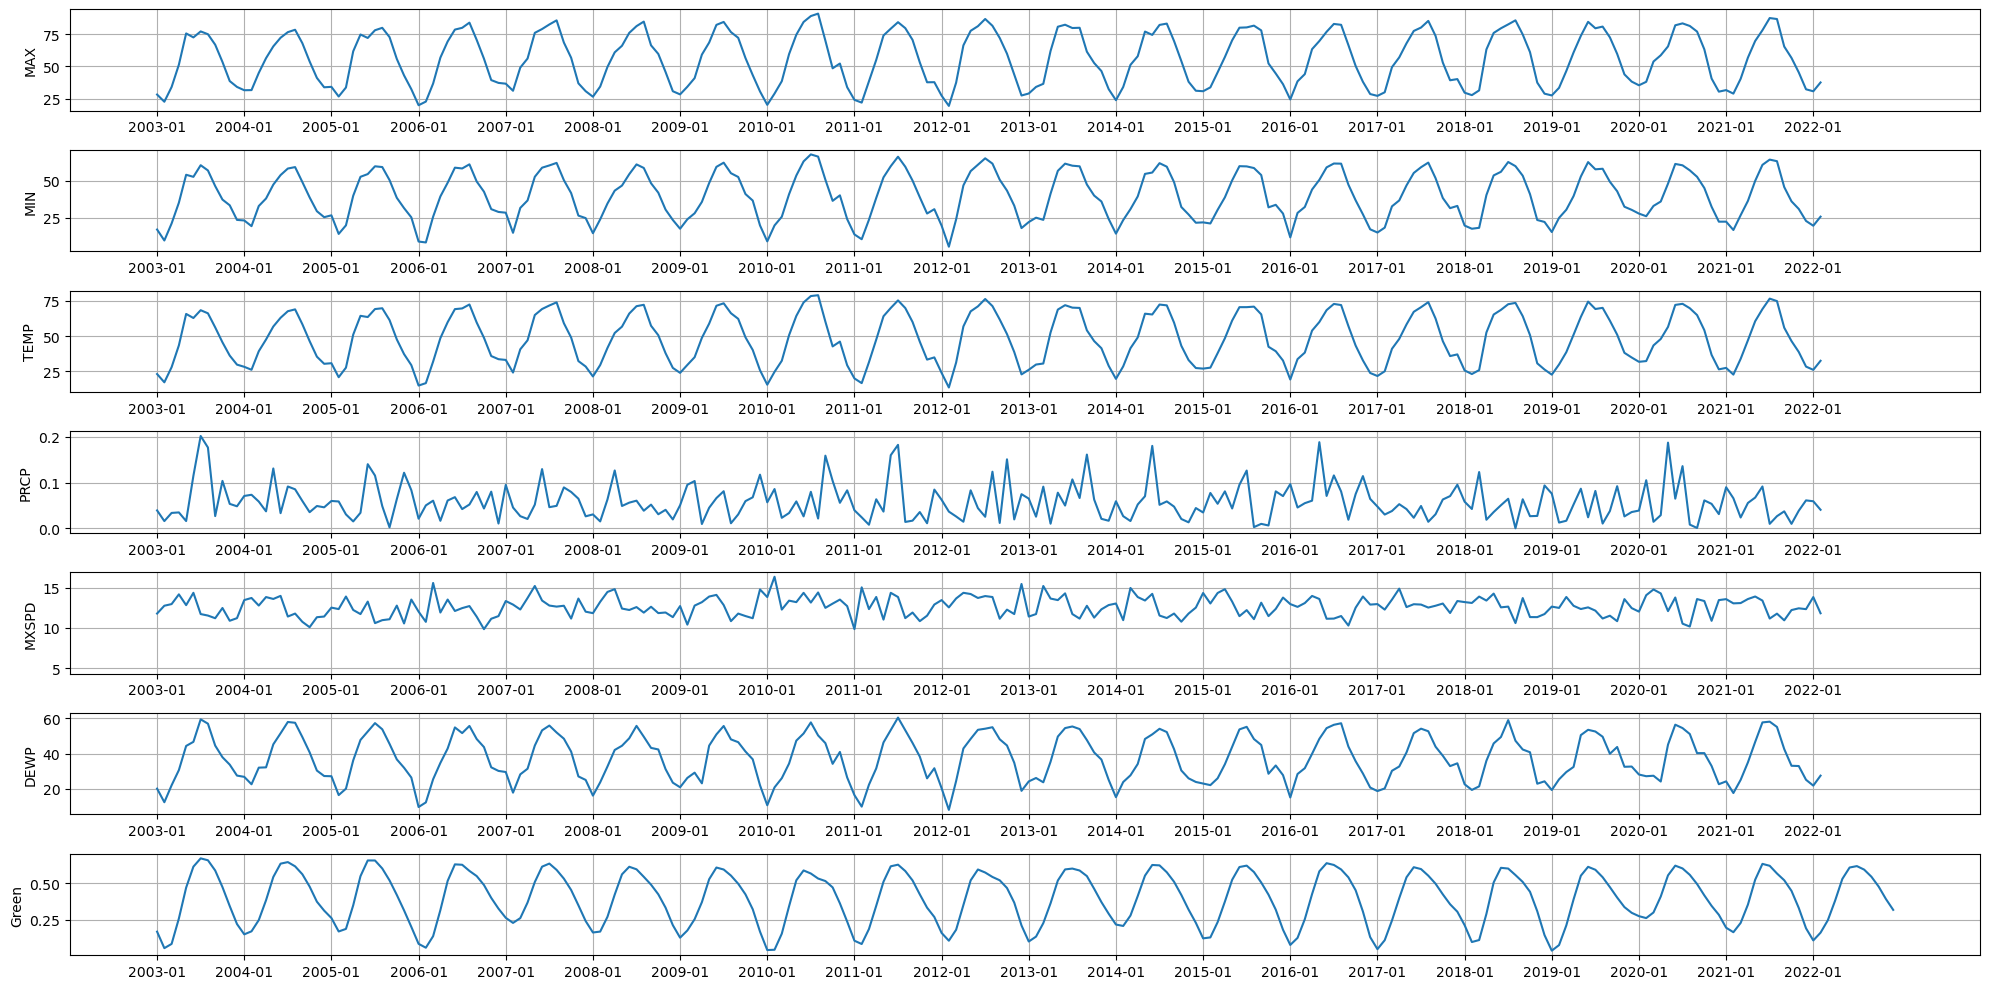

(240,)
(6, 240)


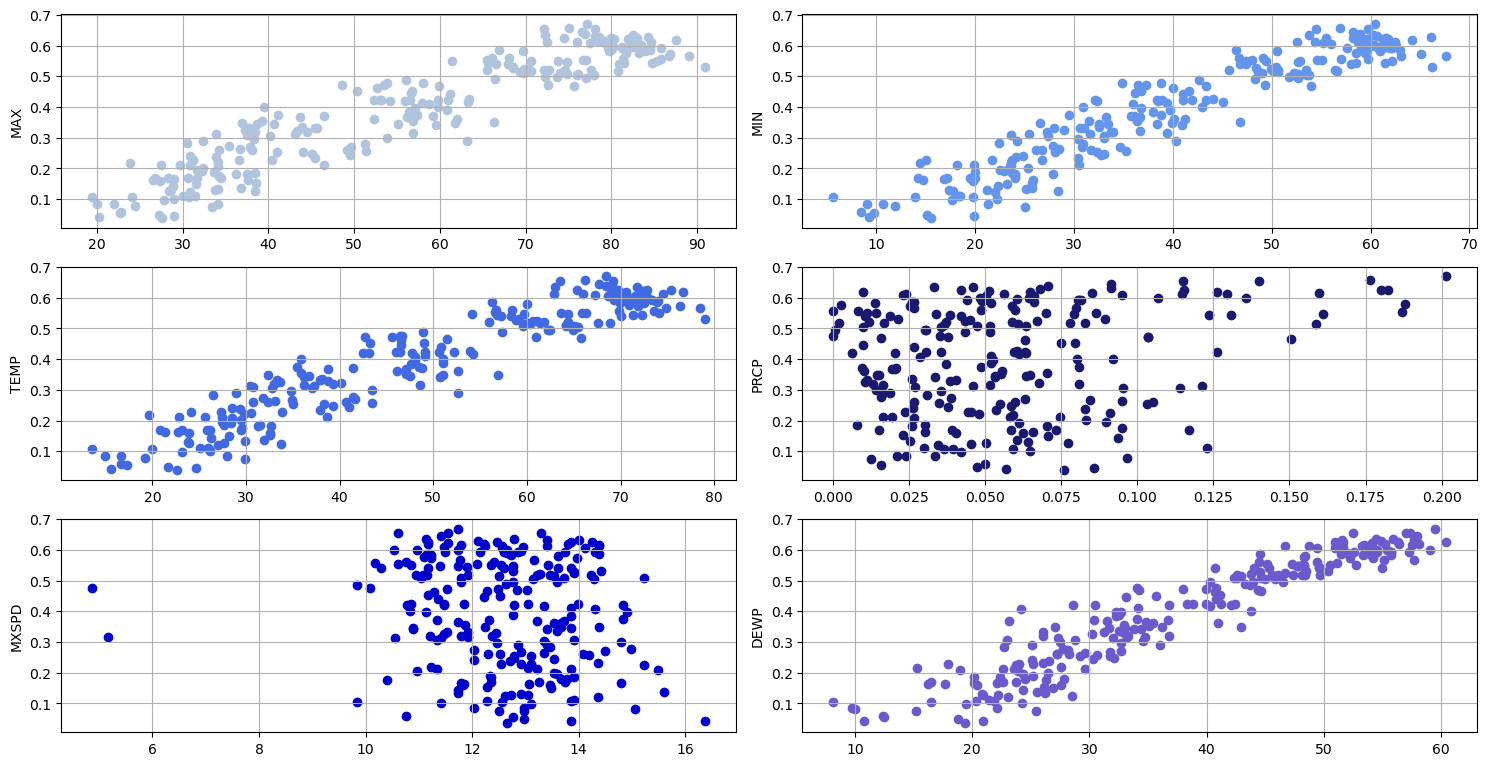

In [3]:
filename_weather = "./FinalData/Ukraine.csv"
filename_green = "./FinalData/uk_green.csv"

wm = WeatherModel(filename_weather)

#Defining score for model
def score(model):
    return ([model[i].aic for i in range(len(model))])

#Making values to look over
wm = WeatherModel(filename_weather)


wm.fit(order=(1, 0, 1))


predictions = wm.predict(start=0, future=365*10)



unrolled_data = wm.year_data.reshape(-1, wm.year_data.shape[2]).T
feature_names = ["MAX", "MIN", "TEMP", "MXSPD", "DEWP", "PRCP"]
for i in range(len(predictions)):
    plt.figure(figsize=(20, 5))
    plt.title(feature_names[i])
    plt.plot(unrolled_data[i])
    plt.plot(predictions[i])
    plt.show()


#Plotting the scatter of feature vs food prioce for triend
feature_names = ["MAX", "MIN", "TEMP", "PRCP", "MXSPD", "DEWP"]

weather = pd.DataFrame(wm.data[feature_names], columns=feature_names)
# weather = pd.DataFrame(wm.residuals, columns=feature_names)
weather["DATE"] = wm.data["DATE"]
weather = weather[(weather["DATE"].dt.year >= 2003) & (weather["DATE"].dt.year <= 2022)]
weather = weather.set_index("DATE")
weather = weather.resample('ME').mean()

green = pd.read_csv(filename_green)
green["#date"] = pd.to_datetime(green["#date"])
green = green[(green["#date"].dt.year >= 2003) & (green["#date"].dt.year <= 2022)]
green = green.set_index("#date")
green["residuals"] = green["#indicator+vim+num"] #- green["#indicator+vim_avg+num"]
green = green["residuals"].resample('ME').mean()

y = green.values
weather = weather.to_numpy().T

plt.figure(figsize=(20, 10))


for i in range(len(weather)):
    plt.subplot(len(weather)+1, 1, i+1)
    plt.plot(weather[i])
    plt.xticks(ticks=np.arange(0, len(green), 12), labels=green.index[::12].strftime('%Y-%m'))
 
    plt.ylabel(feature_names[i])
    plt.grid()


plt.subplot(len(weather)+1, 1, len(weather)+1)
plt.plot(y)
plt.xticks(ticks=np.arange(0, len(green), 12), labels=green.index[::12].strftime('%Y-%m'))
plt.ylabel("Green")
plt.grid()
plt.tight_layout()

plt.show()


c_arr = ["lightsteelblue", "cornflowerblue", "royalblue", "midnightblue", "mediumblue", "slateblue"]
full_feature_names = [
    "Maximum Temperature(Fahrenheit)", 
    "Minimum Temperature(Fahrenheit)", 
    "Mean Temperature(Fahrenhei)", 
    "Precipitation(inches)",
    "Dew point(Fahrenheit)",
    "Maximum Wind Speed (mph)"]

print(y.shape)
print(weather.shape)
plt.figure(figsize=(15, 10))
for i in range(len(weather)):
    plt.subplot(4, 2, i+1)
    plt.scatter(weather[i], y, c=c_arr[i])
    plt.ylabel(feature_names[i])
    plt.grid()

plt.tight_layout()
plt.show()


/var/folders/gx/9rfpwcnn3nv1fbw39974s9vh0000gn/T/ipykernel_25633/2079343653.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.data = self.data.ffill()
/var/folders/gx/9rfpwcnn3nv1fbw39974s9vh0000gn/T/ipykernel_25633/2079343653.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.data = self.data.ffill()
Fitting 5/6 ARMA models:  83%|████████████████▋   | 5/6 [00:01<00:00,  2.47it/s]/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using

Seasonal Predictions (11315, 6)
Residual shape (6, 11316)
Num stacks 31
Num extras 1


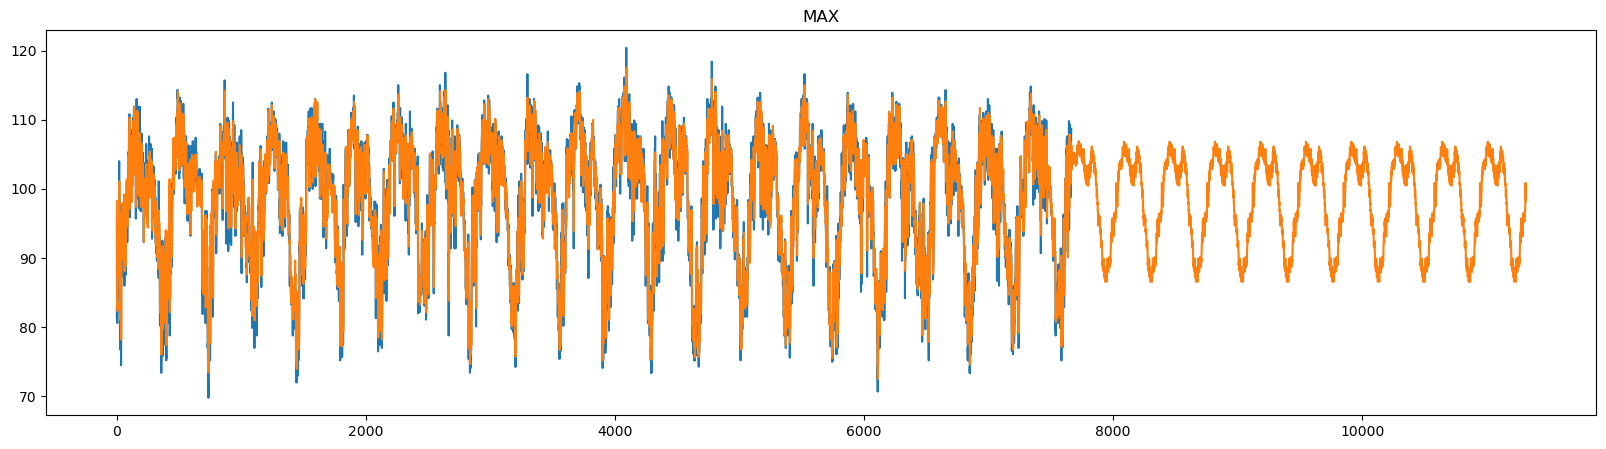

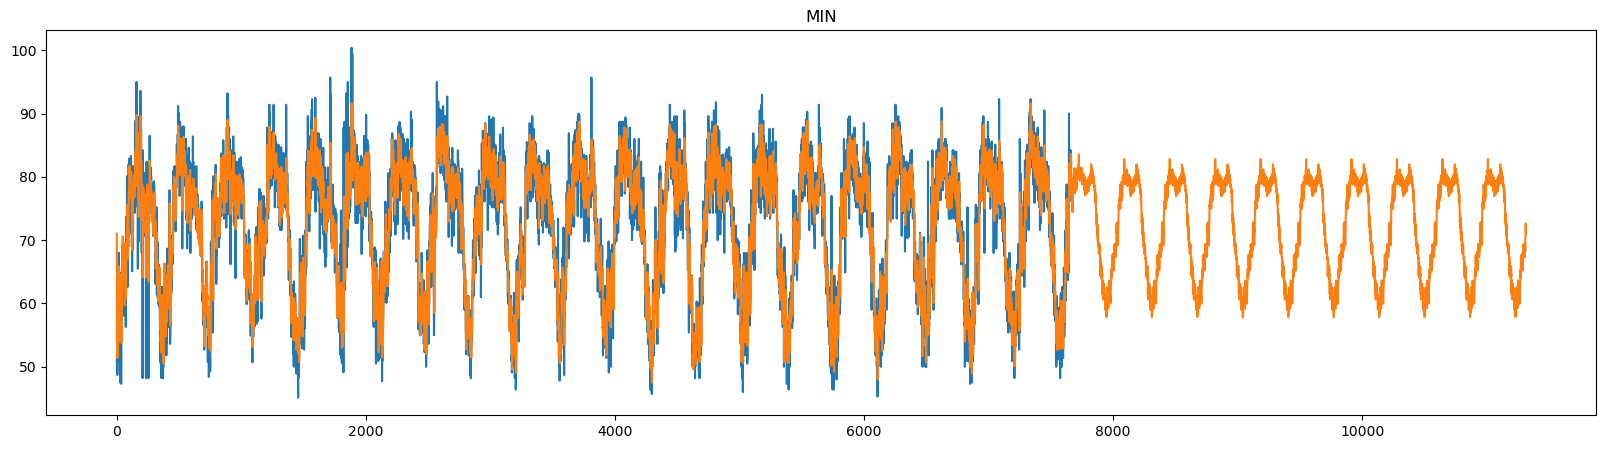

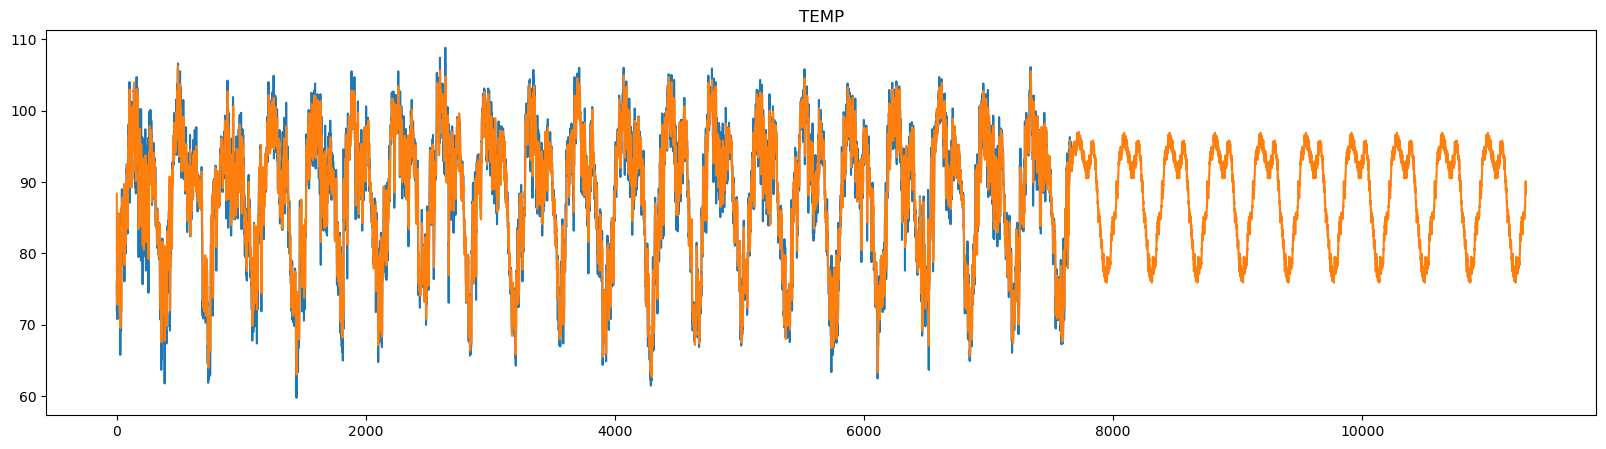

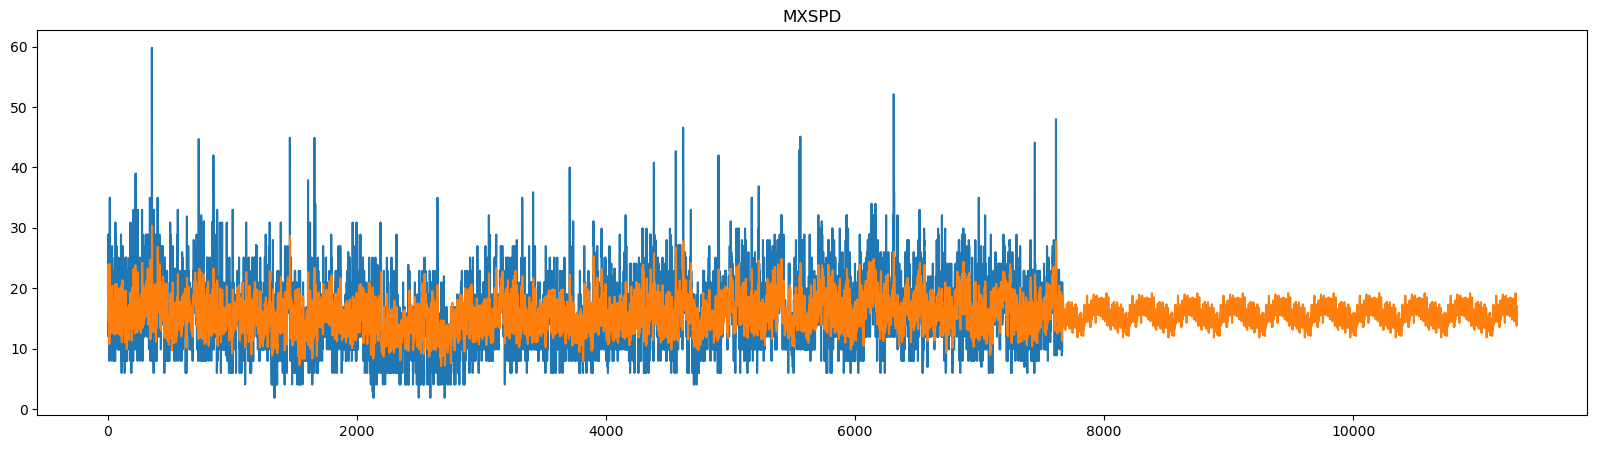

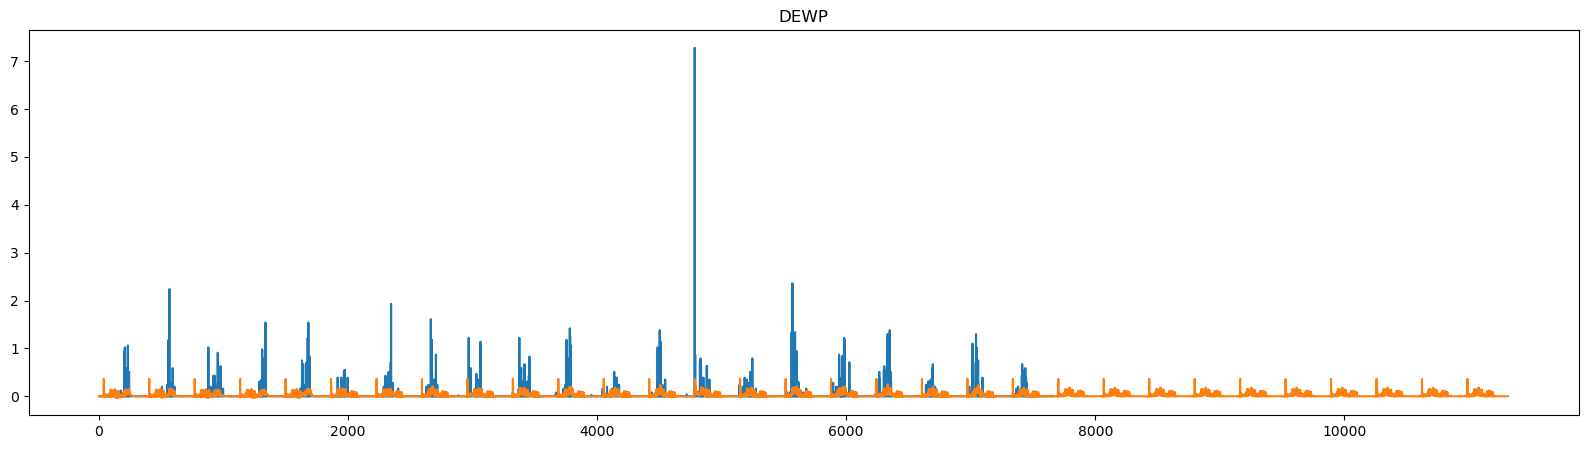

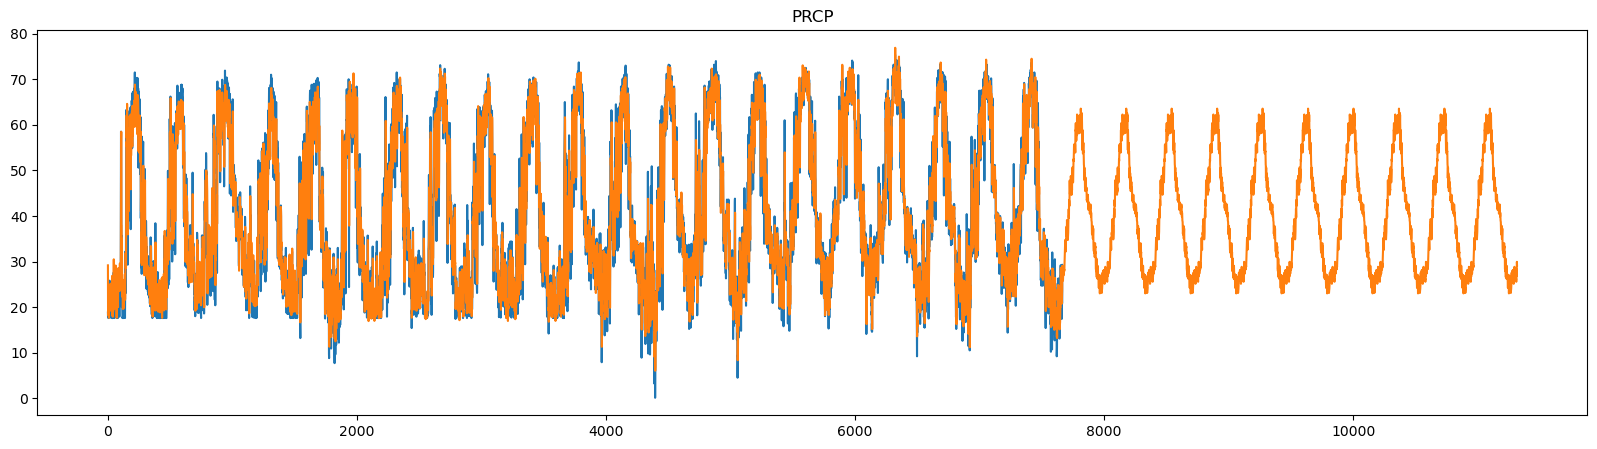

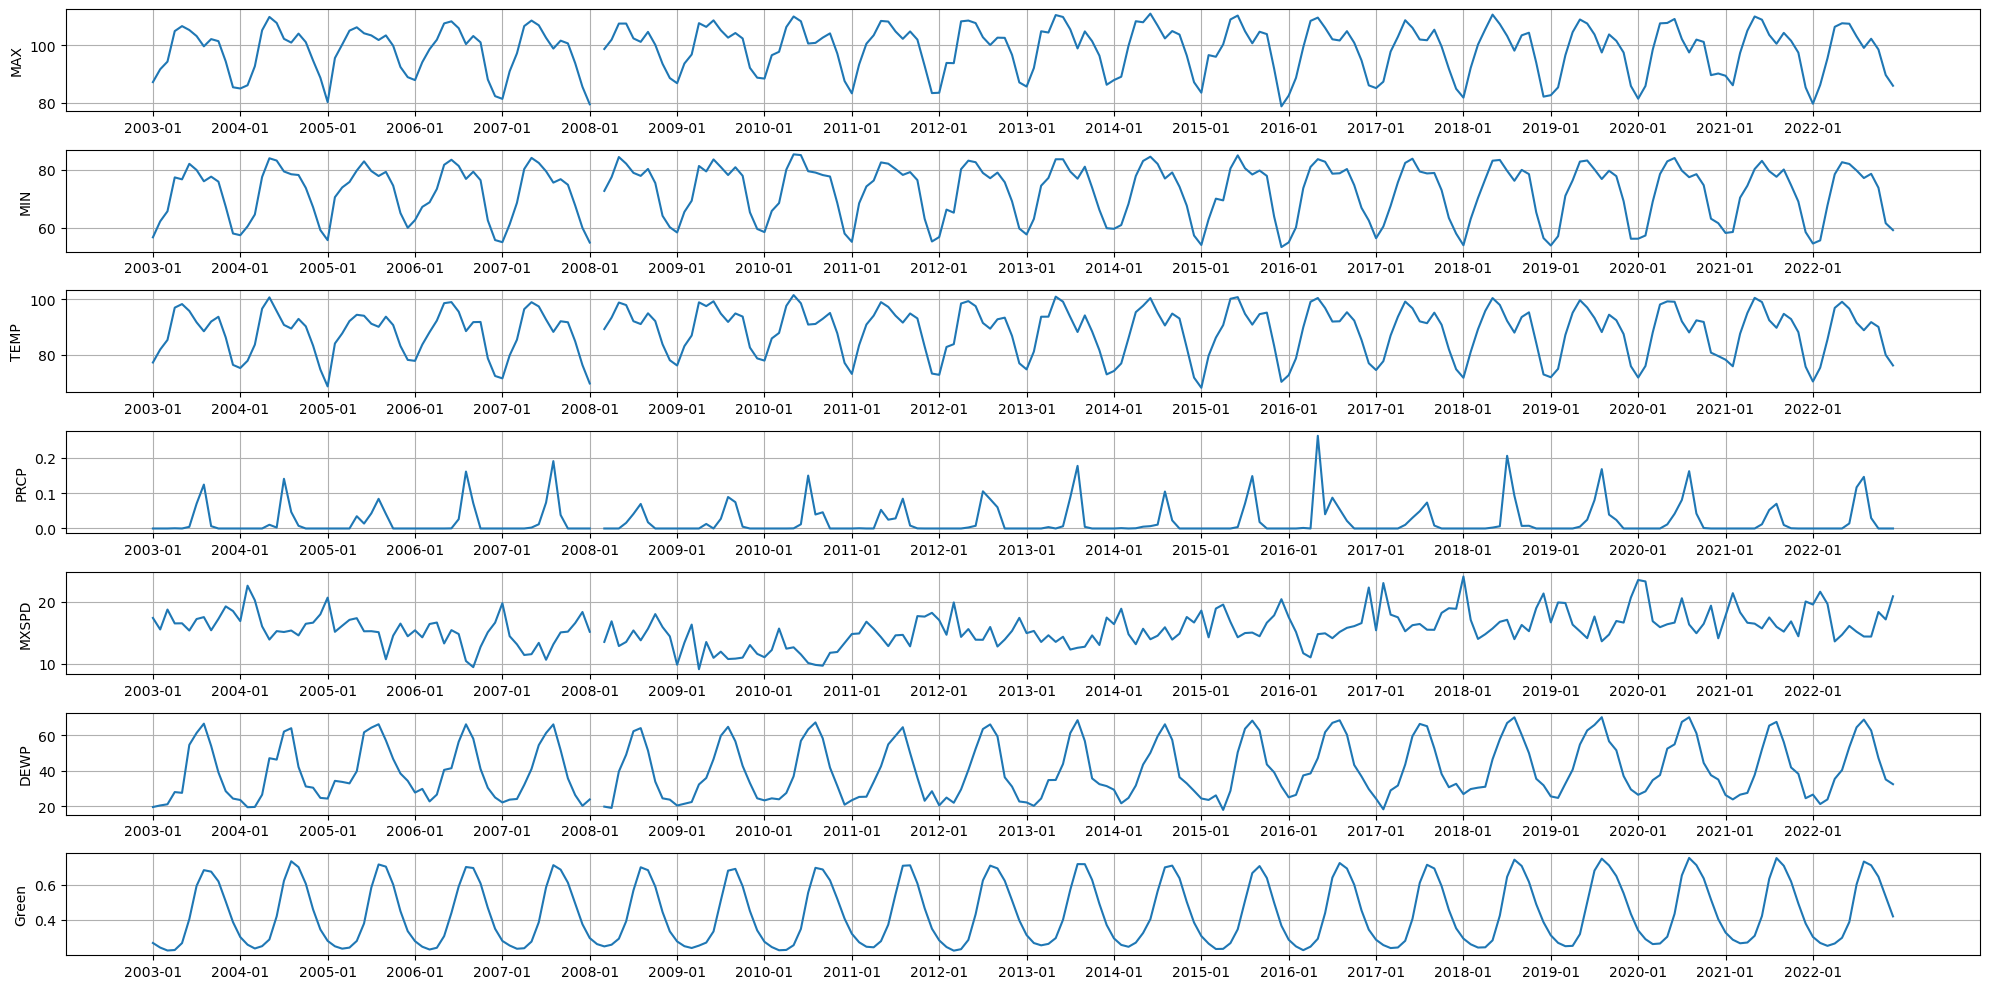

(240,)
(6, 240)


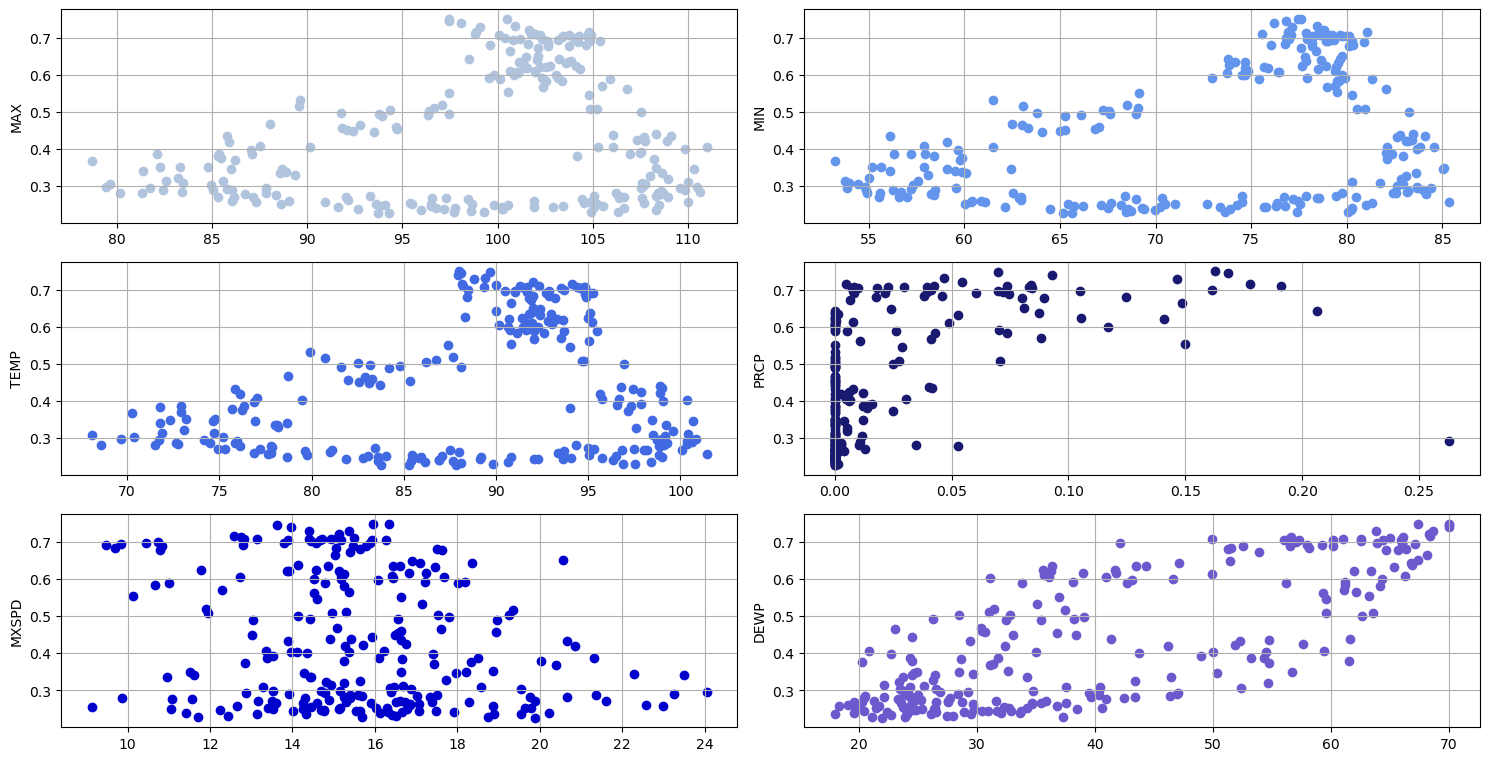

In [4]:
filename_weather = "./FinalData/ph_weather.csv"
filename_food = "./FinalData/ph_food.csv"

wm = WeatherModel(filename_weather)

#Defining score for model
def score(model):
    return ([model[i].aic for i in range(len(model))])

#Making values to look over
wm = WeatherModel(filename_weather)


wm.fit(order=(1, 0, 1))


predictions = wm.predict(start=0, future=365*10)



unrolled_data = wm.year_data.reshape(-1, wm.year_data.shape[2]).T
feature_names = ["MAX", "MIN", "TEMP", "MXSPD", "DEWP", "PRCP"]
for i in range(len(predictions)):
    plt.figure(figsize=(20, 5))
    plt.title(feature_names[i])
    plt.plot(unrolled_data[i])
    plt.plot(predictions[i])
    plt.show()


#Plotting the scatter of feature vs food prioce for triend
feature_names = ["MAX", "MIN", "TEMP", "PRCP", "MXSPD", "DEWP"]

weather = pd.DataFrame(wm.data[feature_names], columns=feature_names)
# weather = pd.DataFrame(wm.residuals, columns=feature_names)
weather["DATE"] = wm.data["DATE"]
weather = weather[(weather["DATE"].dt.year >= 2003) & (weather["DATE"].dt.year <= 2022)]
weather = weather.set_index("DATE")
weather = weather.resample('ME').mean()

green = pd.read_csv(filename_green)
green["#date"] = pd.to_datetime(green["#date"])
green = green[(green["#date"].dt.year >= 2003) & (green["#date"].dt.year <= 2022)]
green = green.set_index("#date")
green["residuals"] = green["#indicator+vim+num"] #- green["#indicator+vim_avg+num"]
green = green["residuals"].resample('ME').mean()

y = green.values
weather = weather.to_numpy().T

plt.figure(figsize=(20, 10))


for i in range(len(weather)):
    plt.subplot(len(weather)+1, 1, i+1)
    plt.plot(weather[i])
    plt.xticks(ticks=np.arange(0, len(green), 12), labels=green.index[::12].strftime('%Y-%m'))
 
    plt.ylabel(feature_names[i])
    plt.grid()


plt.subplot(len(weather)+1, 1, len(weather)+1)
plt.plot(y)
plt.xticks(ticks=np.arange(0, len(green), 12), labels=green.index[::12].strftime('%Y-%m'))
plt.ylabel("Green")
plt.grid()
plt.tight_layout()

plt.show()


c_arr = ["lightsteelblue", "cornflowerblue", "royalblue", "midnightblue", "mediumblue", "slateblue"]
full_feature_names = [
    "Maximum Temperature(Fahrenheit)", 
    "Minimum Temperature(Fahrenheit)", 
    "Mean Temperature(Fahrenhei)", 
    "Precipitation(inches)",
    "Dew point(Fahrenheit)",
    "Maximum Wind Speed (mph)"]

print(y.shape)
print(weather.shape)
plt.figure(figsize=(15, 10))
for i in range(len(weather)):
    plt.subplot(4, 2, i+1)
    plt.scatter(weather[i], y, c=c_arr[i])
    plt.ylabel(feature_names[i])
    plt.grid()

plt.tight_layout()
plt.show()


In [ ]:
filename_weather = "./FinalData/Am_Timan_chad.csv"
filename_green = "./FinalData/chad_green.csv"

wm = WeatherModel(filename_weather)

#Defining score for model
def score(model):
    return ([model[i].aic for i in range(len(model))])

#Making values to look over
wm = WeatherModel(filename_weather)


wm.fit(order=(1, 0, 1))


predictions = wm.predict(start=0, future=365*10)



unrolled_data = wm.year_data.reshape(-1, wm.year_data.shape[2]).T
feature_names = ["MAX", "MIN", "TEMP", "MXSPD", "DEWP", "PRCP"]
for i in range(len(predictions)):
    plt.figure(figsize=(20, 5))
    plt.title(feature_names[i])
    plt.plot(unrolled_data[i])
    plt.plot(predictions[i])
    plt.show()


#Plotting the scatter of feature vs food prioce for triend
feature_names = ["MAX", "MIN", "TEMP", "PRCP", "MXSPD", "DEWP"]

weather = pd.DataFrame(wm.data[feature_names], columns=feature_names)
# weather = pd.DataFrame(wm.residuals, columns=feature_names)
weather["DATE"] = wm.data["DATE"]
weather = weather[(weather["DATE"].dt.year >= 2003) & (weather["DATE"].dt.year <= 2022)]
weather = weather.set_index("DATE")
weather = weather.resample('ME').mean()

green = pd.read_csv(filename_green)
green["#date"] = pd.to_datetime(green["#date"])
green = green[(green["#date"].dt.year >= 2003) & (green["#date"].dt.year <= 2022)]
green = green.set_index("#date")
green["residuals"] = green["#indicator+vim+num"] #- green["#indicator+vim_avg+num"]
green = green["residuals"].resample('ME').mean()

y = green.values
weather = weather.to_numpy().T

plt.figure(figsize=(20, 10))


for i in range(len(weather)):
    plt.subplot(len(weather)+1, 1, i+1)
    plt.plot(weather[i])
    plt.xticks(ticks=np.arange(0, len(green), 12), labels=green.index[::12].strftime('%Y-%m'))
 
    plt.ylabel(feature_names[i])
    plt.grid()


plt.subplot(len(weather)+1, 1, len(weather)+1)
plt.plot(y)
plt.xticks(ticks=np.arange(0, len(green), 12), labels=green.index[::12].strftime('%Y-%m'))
plt.ylabel("Green")
plt.grid()
plt.tight_layout()

plt.show()


c_arr = ["lightsteelblue", "cornflowerblue", "royalblue", "midnightblue", "mediumblue", "slateblue"]
full_feature_names = [
    "Maximum Temperature(Fahrenheit)", 
    "Minimum Temperature(Fahrenheit)", 
    "Mean Temperature(Fahrenhei)", 
    "Precipitation(inches)",
    "Dew point(Fahrenheit)",
    "Maximum Wind Speed (mph)"]

print(y.shape)
print(weather.shape)
plt.figure(figsize=(15, 10))
for i in range(len(weather)):
    plt.subplot(4, 2, i+1)
    plt.scatter(weather[i], y, c=c_arr[i])
    plt.ylabel(feature_names[i])
    plt.grid()

plt.tight_layout()
plt.show()
